# Consigna TP3

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en
Material_TPs / images a partir del template Material_TPs / template

<b> Parte 1 </b> <br>
4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos

<b> Parte 2: </b> <br>
4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen
coca_multi png con el mismo témplate del item 2

<b> Parte 3: </b> <br>
2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes
Visualizar
los resultados con bounding boxes en cada imagen mostrando el nivel de confianza
de la detección


In [49]:
#Si queremos que las imágenes sean mostradas en una ventana emergente descomentar el inline
# %matplotlib

import numpy as np  # OpenCV-Python utiliza NumPy para el manejo de imágenes
import cv2 as cv    # cv2 es el módulo python para acceder a OpenCV 
import matplotlib.pyplot as plt # Usamos las poderosas herramientas de graficación de matplotlib para mostrar imágenes, perfiles, histogramas, etc
import os
import imutils
from imutils.object_detection import non_max_suppression



# Parte 1

## Cargo imagenes

Text(0.5, 1.0, 'Template - Canny')

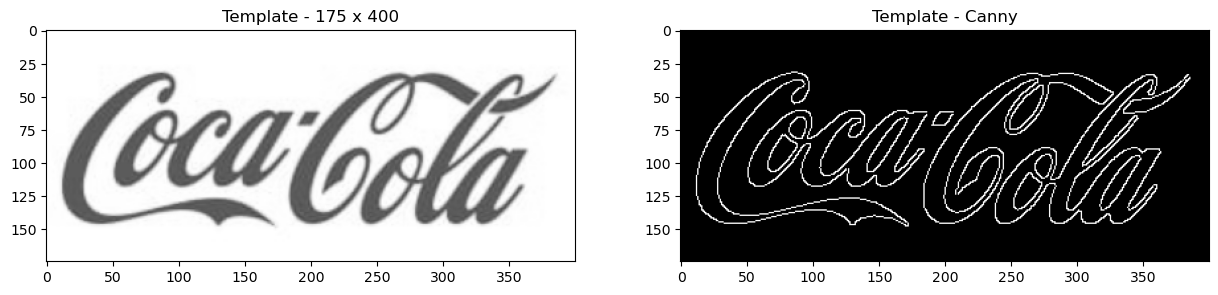

In [50]:
template = cv.imread("template/pattern.png")
template = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(cv.cvtColor(template, cv.COLOR_BGR2RGB))
plt.title(f'Template - {template.shape[0]} x {template.shape[1]}')
# Ahora extraigo los bordes exclusivamente
plt.subplot(1,2,2)
template = cv.Canny(template, 50, 200)
tH, tW = template.shape[:2]
plt.imshow(cv.cvtColor(template, cv.COLOR_BGR2RGB))
plt.title('Template - Canny')

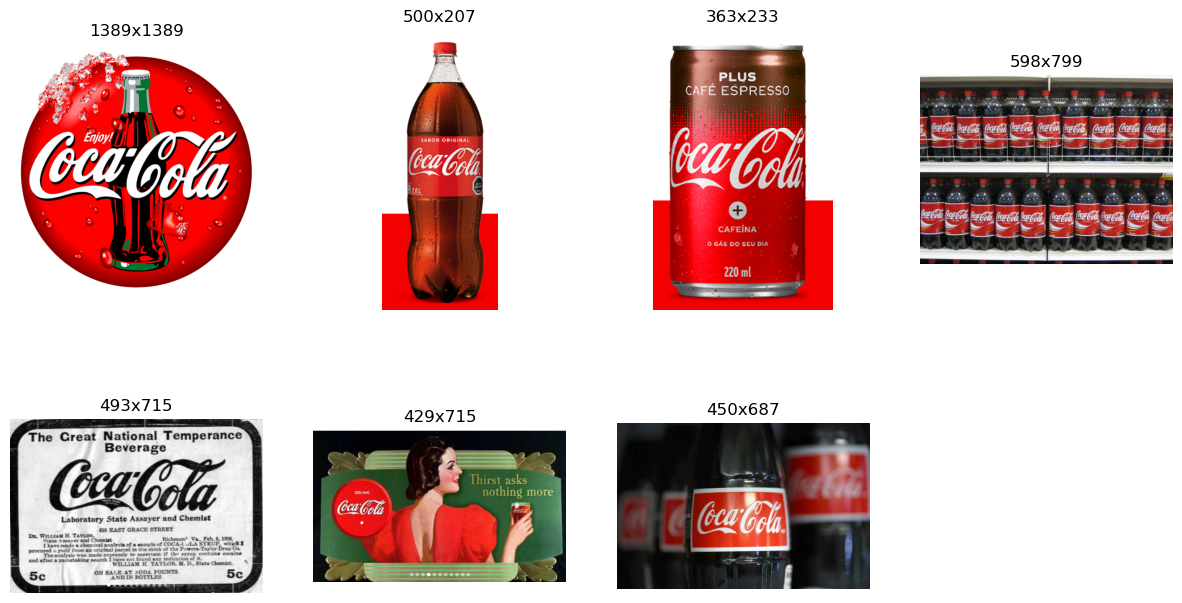

In [51]:
# Ahora veamos las imagenes donde hay que identificar los logos
path_img_dir = 'images'
path_imgs = os.listdir(path_img_dir) # 7 imagenes

imgs=[]
plt.figure(figsize=(15,8))
for i in range(len(path_imgs)):
    imgs.append(cv.imread(os.path.join(path_img_dir,path_imgs[i])))
    plt.subplot(2,4,i+1)
    plt.imshow(cv.cvtColor(imgs[i], cv.COLOR_BGR2RGB))
    plt.title(f'{imgs[i].shape[0]}x{imgs[i].shape[1]}')
    plt.axis('off')


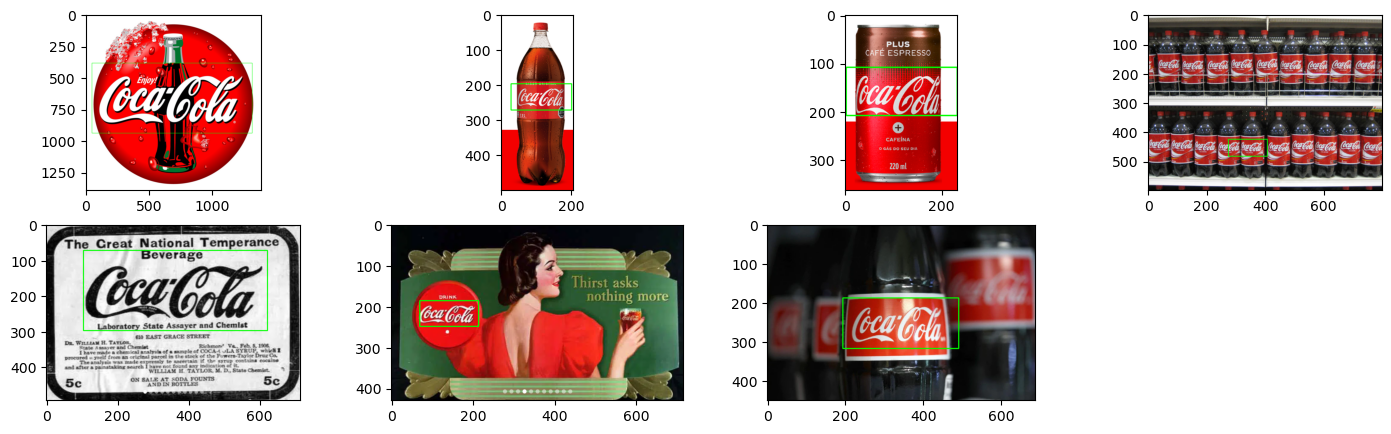

In [53]:
def Plot(img):
    plt.figure()
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

# Ahora hacemos template matching con la piramide para cada imagen target.
min_w = 10      # px image piramid min width
max_w = 1000    # px image piramid max width

canny_th1 = 100
canny_th2 = 200
methods = [cv.TM_CCOEFF, cv.TM_CCOEFF_NORMED, cv.TM_CCORR,
            cv.TM_CCORR_NORMED, cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]
method = methods[0]
imgs_output = []

for i in range(len(imgs)):
    target = cv.cvtColor(imgs[i], cv.COLOR_BGR2GRAY)    # optimizo procesamiento
    h_target, w_target = target.shape[:2]

    # Inicializo variables para guardar resultados
    match_vals = []
    match_locs = []
    match_scale = []
    # Creamos pirámide de imagen y matcheamos
    min_linsp = min_w/w_target
    max_linsp = max_w/w_target
    for scale in np.linspace(0.2, 3, 50)[::-1]:   # Iterate from largest to smallest
        resized = imutils.resize(target, width = int(target.shape[1] * scale))
        new_w = int(resized.shape[1])
        new_h = int(resized.shape[0])
        if(new_h < tH or new_w < tW):  
            break   # Dejo de iterar si la imagen es mas chica que el template
        edged = cv.Canny(resized, canny_th1, canny_th2)
        # Plot(template)
        # Plot(resized)
        res = cv.matchTemplate(edged, template, method)
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
        match_vals.append(max_val)
        match_locs.append(max_loc)
        match_scale.append(scale)

    # Ahora, para cada imagen, obtengo el indice de la mejor coincidencia
    idx = np.argmax(match_vals)
    scale = match_scale[idx]

    # Dibujo el roi en la imagen target
    Xo, Yo = np.divide(match_locs[idx], scale)
    h_src, w_src = tH/scale, tW/scale  
    (Xo, Yo) = (int(Xo), int(Yo))
    (Xf, Yf) = (int(Xo+w_src), int(Yo+h_src))
    target = imgs[i].copy()
    cv.rectangle(target, (Xo, Yo), (Xf, Yf), (0, 255, 0), 2)
    imgs_output.append(target)

plt.figure(figsize=(18,5))
for i in range(len(imgs_output)):
    plt.subplot(2,4,i+1)
    plt.imshow(cv.cvtColor(imgs_output[i], cv.COLOR_BGR2RGB))


# Parte 2

(-0.5, 798.5, 597.5, -0.5)

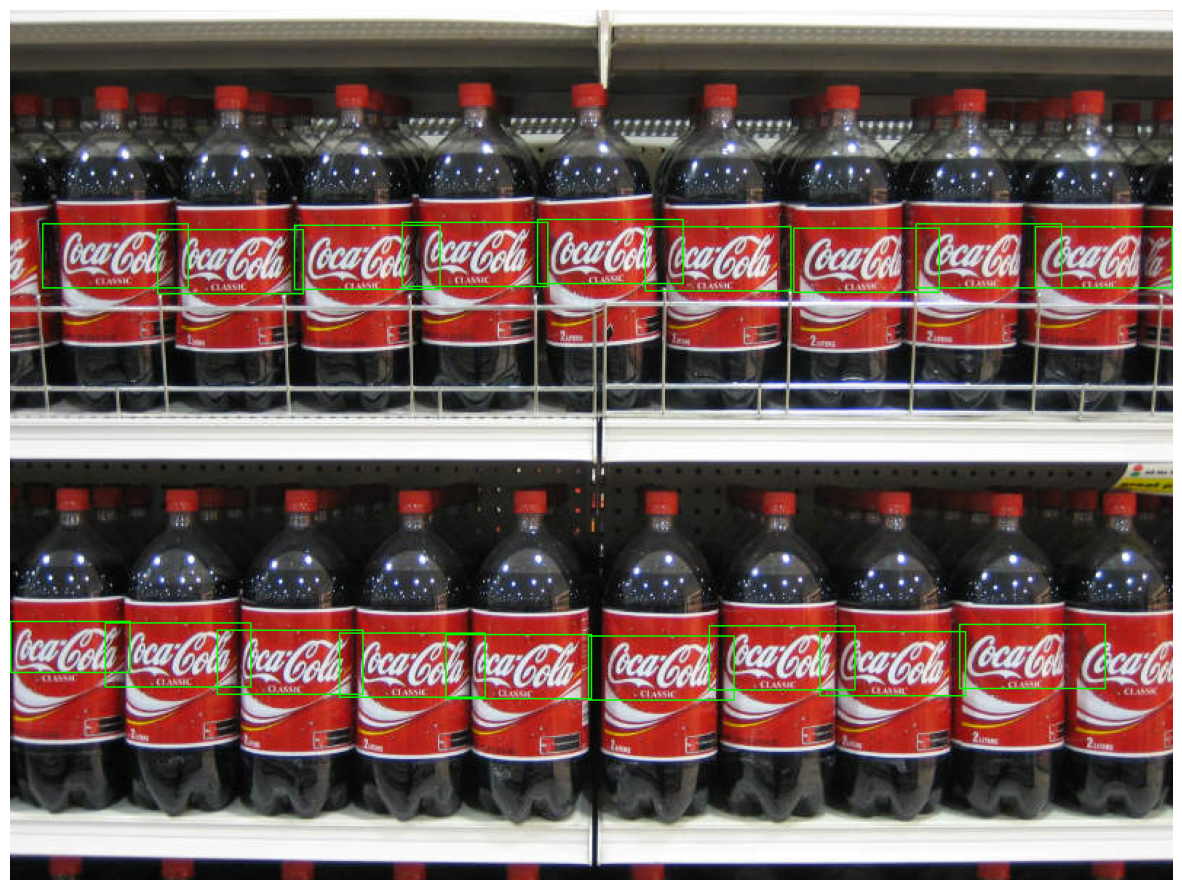

In [54]:
multi = imgs[3].copy()
target = cv.cvtColor(multi, cv.COLOR_BGR2GRAY)
coord = []
non_repeated = []   
canny_th1 = 200
canny_th2 = 255
threshold = 0.06    # Threshold for detecting maximums in match template
for scale in np.linspace(4, 6, 10)[::-1]:   # Iterate from largest to smallest
    resized = imutils.resize(target, width = int(target.shape[1] * scale))
    new_w = int(resized.shape[1])
    new_h = int(resized.shape[0])
    if(new_h < tH or new_w < tW):  
        break   # Dejo de iterar si la imagen es mas chica que el template
    edged = cv.Canny(resized, canny_th1, canny_th2)
    res = cv.matchTemplate(edged, template, cv.TM_CCOEFF_NORMED)
    loc = np.where(res > threshold)
    for pt in zip(*loc[::-1]):
        coord.append((  int(pt[0]/scale)  ,  int(pt[1]/scale)  ,  int((pt[0] + tW)/scale)  ,  int((pt[1] + tH)/scale) )) 
    non_repeated = non_max_suppression(np.array(coord))

for (xb, yb, xe, ye) in non_repeated:
	cv.rectangle(multi, (xb, yb), (xe, ye), (0, 255, 0), 1)
plt.figure(figsize=(15,15))
plt.imshow(cv.cvtColor(multi, cv.COLOR_BGR2RGB))
plt.axis(False)